# [RSNA-MICCAI Brain Tumor Radiogenomic Classification](https://www.kaggle.com/competitions/rsna-miccai-brain-tumor-radiogenomic-classification)

## Refference

[Determining MR Slice Orientation](https://www.kaggle.com/code/davidbroberts/determining-mr-slice-orientation)

The goal of this notebook is to demonstrate how an MR slice is orientated relative to the patient's body.¶
We'll use the DICOM tag ImageOrientationPatient to get positioning markers and draw them onto slices.

- The position markers can be a single letter or a combination of up to three letters ..¶

    - A = Anterior  
    - P = Posterior
    - H = Head
    - F = Feet
    - L = Left
    - R = Right

- Position markers that are multiple letters indicate obliqueness (rotation) toward one or more axes.
- I.E .. A letter marker of "LH" indicates the primary axis is Left, but the image is rotated in the Head direction.
- More info can be found in the Image Plane Module of the DICOM Standard -> http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.7.6.2.html¶

## - Define some functions

In [1]:
import matplotlib
import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt

In [2]:
def normalize_pixels(pixels):
    pixels = pixels - np.min(pixels)
    pixels = pixels / np.max(pixels)
    pixels = (pixels * 255).astype(np.uint8)
    return pixels

In [3]:
def get_marker(iop, i):
    
    # Get the primary axis orientation markers. Get IOP vector values starting at 'i'
    # Use the first three values for right, and last three for bottom.
    Xx = 'R' if iop[i] < 0 else 'L'
    Yx = 'A' if iop[i+1] < 0 else 'P'
    Zx = 'F' if iop[i+2] < 0 else 'H'
    
    or1 = ""
    absX = abs(iop[i])
    absY = abs(iop[i+1])
    absZ = abs(iop[i+2])

    # Add oblique markers if not orthogonal
    for i in range(0,3):
        if absX > .0001 and absX > absY and absX > absZ:
            or1 += Xx
            absX = 0
        elif absY > .0001 and absY > absX and absY > absZ:
            or1 += Yx
            absY=0
        elif absZ > .0001 and absZ > absX and absZ > absY:
            or1 += Zx
            absZ = 0
        else:
            break
            
    return or1

In [4]:
def get_markers(iop):
    marker_right = get_marker(iop, 0)
    marker_bottom = get_marker(iop, 3)
    return marker_right, marker_bottom

In [5]:
def draw_markers(pixels, marker_r, marker_b):
    color = (255,255,255)
    font = cv2.FONT_HERSHEY_SIMPLEX
    img2_pixels = cv2.putText(pixels, marker_r,(int(pixels.shape[1] - 65),int(pixels.shape[0] / 2)), font, 1, color, 2, cv2.LINE_AA)
    img2_pixels = cv2.putText(pixels, marker_b,(int(pixels.shape[1] / 2 - 20),int(pixels.shape[0] - 25)), font, 1, color, 2, cv2.LINE_AA)
    return pixels

In [6]:
# Get the relavent tags and calculate the coordinates that specify the 'box' that one image projects onto another
def create_reference_line(src, dst):
    dst_iop = dst.ImageOrientationPatient
    dst_ipp = dst.ImagePositionPatient
    src_iop = src.ImageOrientationPatient
    src_ipp = src.ImagePositionPatient  

    pos_x = []
    pos_y = []
    pos_z = []
    row_pixel = []
    col_pixel = []

    row_len = int(dst.Rows * dst.PixelSpacing[1])
    col_len = int(dst.Columns * dst.PixelSpacing[0])
    
    # Get the coordinates of the box
    pos_x.append(src_ipp[0]) # Top Left Corner
    pos_y.append(src_ipp[1])
    pos_z.append(src_ipp[2])
    pos_x.append(src_ipp[0] + src_iop[0] * row_len) # Top Right Corner
    pos_y.append(src_ipp[1] + src_iop[1] * row_len)
    pos_z.append(src_ipp[2] + src_iop[2] * row_len)
    pos_x.append(src_ipp[0] + src_iop[0] * row_len + src_iop[3] * col_len) # Bottom Right Corner
    pos_y.append(src_ipp[1] + src_iop[1] * row_len + src_iop[4] * col_len)
    pos_z.append(src_ipp[2] + src_iop[2] * row_len + src_iop[5] * col_len)
    pos_x.append(src_ipp[0] + src_iop[3] * col_len) # Bottom Left Corner
    pos_y.append(src_ipp[1] + src_iop[4] * col_len)
    pos_z.append(src_ipp[2] + src_iop[5] * col_len)
    
    for i in range (0,3):
    
        pos_x[i] -= dst_ipp[0]
        pos_y[i] -= dst_ipp[1]
        pos_z[i] -= dst_ipp[2]
        
        # Rotate the coordinates in 3D space
        cp = int(dst_iop[0] * pos_x[i] + dst_iop[1] * pos_y[i] + dst_iop[2] * pos_z[i])
        rp = int(dst_iop[3] * pos_x[i] + dst_iop[4] * pos_y[i] + dst_iop[5] * pos_z[i])

        col_pixel.append(int(cp / float(dst.PixelSpacing[0])))
        row_pixel.append(int(rp / float(dst.PixelSpacing[1])))
    
    return col_pixel, row_pixel

Open two images from the same study, in different planes.¶

In [7]:
# Read in two images from the same study, different series.
img1 = pydicom.dcmread('../01_input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00021/FLAIR/Image-140.dcm')
img2 = pydicom.dcmread('../01_input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00021/T2w/Image-223.dcm')
   
# Crunch the pixels down to 8 bit so we can draw an 8 bit graphics on them
img1_pixels = normalize_pixels(img1.pixel_array)
img2_pixels = normalize_pixels(img2.pixel_array)

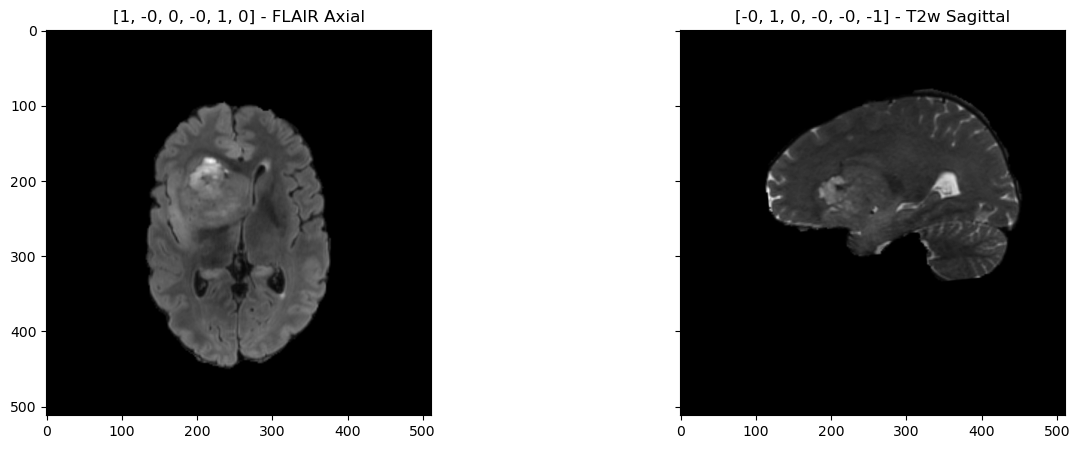

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True, figsize=(15, 5))
ax = axes.ravel()
ax[0].set_title(f'{img1.ImageOrientationPatient} - FLAIR Axial')
ax[0].imshow(img1.pixel_array, cmap='gray');
ax[1].set_title(f'{img2.ImageOrientationPatient} - T2w Sagittal')
ax[1].imshow(img2.pixel_array, cmap='gray');

- The slice on the left is Axial plane, the one on the right is Sagittal.¶
- We can see from the ImageOrientationPatient tag values that these images are orthogonal to all three planes of the patient coordinate system.
- The cosine values are all zero or one.
- Now, we'll use the ImageOrientationTag to add position markers to the right and bottom of the image.

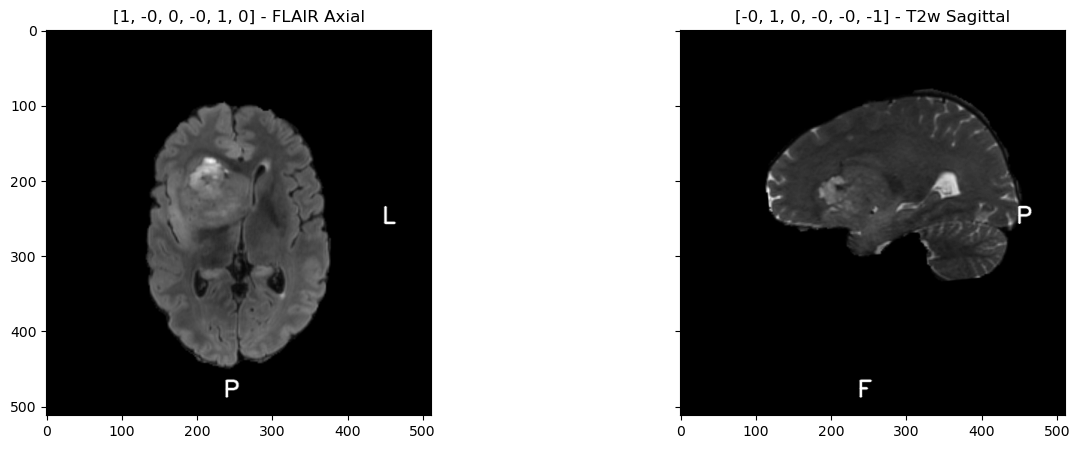

In [10]:
# Get markers and draw them on the pixels
img1_marker_r, img1_marker_b = get_markers(img1.ImageOrientationPatient)
img2_marker_r, img2_marker_b = get_markers(img2.ImageOrientationPatient)

img1_pixels = draw_markers(img1_pixels, img1_marker_r, img1_marker_b)
img2_pixels = draw_markers(img2_pixels, img2_marker_r, img2_marker_b)   
    
# Plot the results
fig, axes = plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True, figsize=(15, 5))
ax = axes.ravel()
ax[0].set_title(f'{img1.ImageOrientationPatient} - FLAIR Axial')
ax[0].imshow(img1_pixels, cmap='gray');
ax[1].set_title(f'{img2.ImageOrientationPatient} - T2w Sagittal')
ax[1].imshow(img2_pixels, cmap='gray');

- Now, we have Left and Posterior markers on the axial image, and the Feet/Posterior markers on the sagittal.¶
- This tells us that we're viewing the axial slice as if we're standing at the patient's feet.¶
- Let's plot out reference lines so we can visualize the orientation of the images onto the each other.

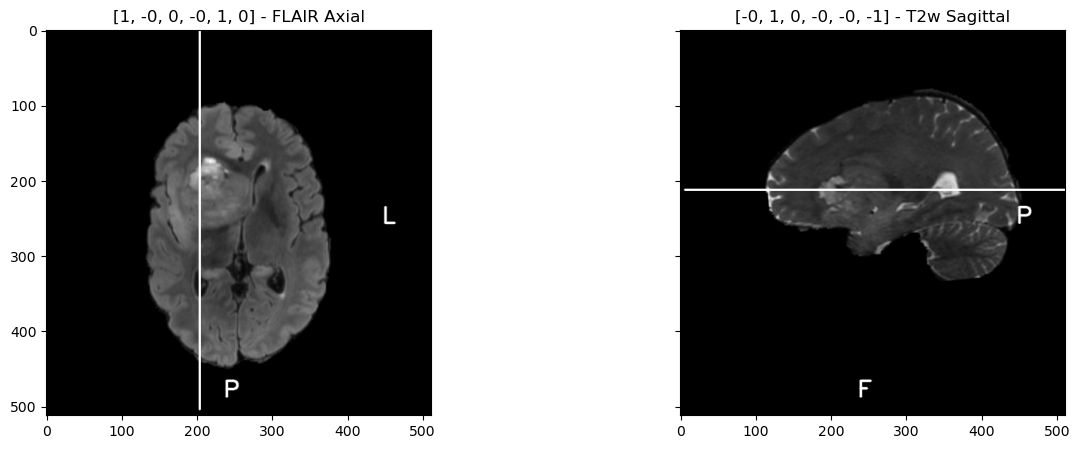

In [11]:
# Project reference line from img2 onto img1  
col_pixel, row_pixel = create_reference_line(img2, img1)
for i in range(0,2):
    img1_pixels = cv2.line(img1_pixels, (col_pixel[i], row_pixel[i]), (col_pixel[i+1], row_pixel[i+1]), (255, 255, 255), 2)
    
# Project reference line from img1 onto img2
col_pixel, row_pixel = create_reference_line(img1, img2)
for i in range(0,2):
    img2_pixels = cv2.line(img2_pixels, (col_pixel[i], row_pixel[i]), (col_pixel[i+1], row_pixel[i+1]), (255, 255, 255), 2)
    
# Plot the results
fig, axes = plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True, figsize=(15, 5))
ax = axes.ravel()
ax[0].set_title(f'{img1.ImageOrientationPatient} - FLAIR Axial')
ax[0].imshow(img1_pixels, cmap='gray');
ax[1].set_title(f'{img2.ImageOrientationPatient} - T2w Sagittal')
ax[1].imshow(img2_pixels, cmap='gray');

- Now we can see how the slices are spatially aligned to each other and in which orientation.¶
- Let's try another study ..

In [13]:
# Read in two images from the same study, different series.
img1 = pydicom.dcmread('../01_input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00025/FLAIR/Image-350.dcm')
img2 = pydicom.dcmread('../01_input/rsna-miccai-brain-tumor-radiogenomic-classification/train/00025/T1wCE/Image-55.dcm')
   
# Crunch the pixels down to 8 bit so we can draw an 8 bit graphics on them
img1_pixels = normalize_pixels(img1.pixel_array)
img2_pixels = normalize_pixels(img2.pixel_array)

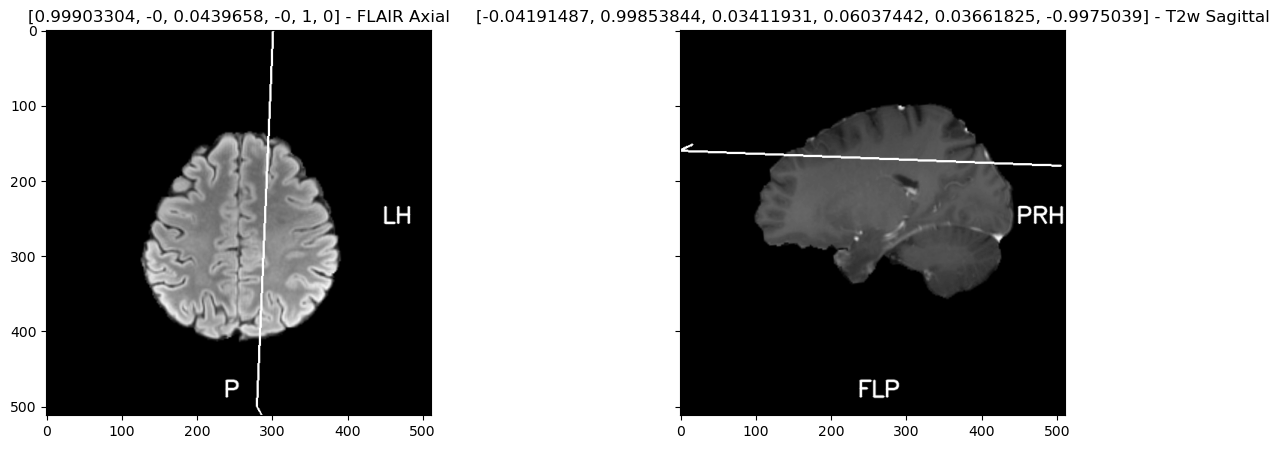

In [14]:
# Get markers and draw them on the pixels
img1_marker_r, img1_marker_b = get_markers(img1.ImageOrientationPatient)
img2_marker_r, img2_marker_b = get_markers(img2.ImageOrientationPatient)

img1_pixels = draw_markers(img1_pixels, img1_marker_r, img1_marker_b)
img2_pixels = draw_markers(img2_pixels, img2_marker_r, img2_marker_b)   

col_pixel, row_pixel = create_reference_line(img2, img1)
for i in range(0,2):
    img1_pixels = cv2.line(img1_pixels, (col_pixel[i], row_pixel[i]), (col_pixel[i+1], row_pixel[i+1]), (255, 255, 255), 2)
    
# Project reference line from img1 onto img2
col_pixel, row_pixel = create_reference_line(img1, img2)
for i in range(0,2):
    img2_pixels = cv2.line(img2_pixels, (col_pixel[i], row_pixel[i]), (col_pixel[i+1], row_pixel[i+1]), (255, 255, 255), 2)
# Plot the results
fig, axes = plt.subplots(nrows=1, ncols=2,sharex=True, sharey=True, figsize=(15, 5))
ax = axes.ravel()
ax[0].set_title(f'{img1.ImageOrientationPatient} - FLAIR Axial')
ax[0].imshow(img1_pixels, cmap='gray');
ax[1].set_title(f'{img2.ImageOrientationPatient} - T2w Sagittal')
ax[1].imshow(img2_pixels, cmap='gray');


- Now we have Posterior and Left/Head on the axial. Notice the reference lines aren't at right angles.¶
- Feet/Left/Posterior and Posterior/Right/Head on the sagittal.
- Notice the ImageOrientationPatient values are not whole numbers. This means the image is rotated along that axis.
- The result can be visualized with the reference line .. The images are slightly obliqued.¶


###  Conclusion:

- We can determine the laterality on slices as well as check their level of obliqueness by using the DICOM ImageOrientationPatient tag.¶
- This can also allow us to relate coordinates between two slices more accurately.